In [1]:
# Task 0: Importing relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from scipy.stats.qmc import LatinHypercube

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Trying out LHS; Nothing to do with the real code
sampler = LatinHypercube(d=2)
sample_list = sampler.integers(l_bounds=0,u_bounds=20, n=35)
sample = [tuple(ele) for ele in sample_list]

In [3]:
# Task 1: Defining maze

"""
Input:
1. Size of Maze
2. Number of coins
3. Number of enemies

Output:
1. Maze, initialised to a 2D NumPy array of zero values
2. Position of coins, returned as a list of tuples
3. Position of enemies, returned as a list of tuples
"""

class Maze:
    
    def __init__(self, size_of_maze, nr_of_coins, nr_of_enemies, sampling):
        self.size = size_of_maze
        self.nr_of_coins = nr_of_coins
        self.nr_of_enemies = nr_of_enemies
        self.sampling = sampling
        
        self.maze = np.zeros((self.size, self.size), dtype=int)
        self.coin_pos = [divmod(ele, self.size - 1) for ele in random.sample(range(1, (self.size - 1) * (self.size - 1)), self.nr_of_coins)]
        self.enemy_pos = [divmod(ele, self.size - 1) for ele in random.sample(range(1, (self.size - 1) * (self.size - 1)), self.nr_of_enemies)]
        
        self.sampler = LatinHypercube(d=2)
        self.sample_coins = sampler.integers(l_bounds = 0,u_bounds = self.size - 1, n = self.nr_of_coins)
        self.sample_enemies = sampler.integers(l_bounds = 0,u_bounds = self.size - 1, n = self.nr_of_enemies)
        self.coin_pos_lhs = [tuple(ele) for ele in self.sample_coins]
        self.enemy_pos_lhs = [tuple(ele) for ele in self.sample_enemies]

In [4]:
# Task 2: The A-star path-finding algorithm

class Node():

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def calculate_cost(current_node, new_node, avoided_nodes):
    # Modify this function to assign a high cost to specific nodes
    if new_node.position in avoided_nodes:
        return -1  # Assign a high cost to the avoided nodes
    else:
        return 1  # Default cost for other nodes


def calculate_heuristic(node, end_node, avoided_nodes):
    # Modify this function to assign a high heuristic value to specific nodes
    if node.position in avoided_nodes:
        return 300  # Assign a high heuristic value to the avoided nodes
    else:
        return ((node.position[0] - end_node.position[0]) ** 2) + ((node.position[1] - end_node.position[1]) ** 2)


def AStar(maze, start, end, avoided_nodes):

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed lists
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            path_tuple = path[::-1]
            return path_tuple  # Return reversed path

        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (
                    len(maze[len(maze) - 1]) - 1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + calculate_cost(current_node, child, avoided_nodes)
            child.h = calculate_heuristic(child, end_node, avoided_nodes)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)

In [5]:
# Task 3: Player profiling and path traversal

"""
Input:
1. Instance of the maze class
2. Player type: Neutral, Greedy, Aggressive

Output:
1. Coins collected after path traversal and reaching the end node
2. Enemies defeated after path traversal and reaching the end node
3. Steps taken from start node to end node
4. Path, in the form of list of tuples for all the nodes the player has traversed
"""

def Player(maze, player_type):
    
    # Task 3a: Initialising maze parameters
    m = maze
    current_pos = (0, 0)
    end_pos = (m.size - 1, m.size - 1)
    if m.sampling == 'LHS':
        coin_pos = m.coin_pos_lhs
        enemy_pos = m.enemy_pos_lhs
    elif m.sampling == 'Random':
        coin_pos = m.coin_pos
        enemy_pos = m.enemy_pos
    else:
        raise TypeError('Only sampling accepted is \'LHS\' and \'Random\'')
    #print(len(coin_pos), len(enemy_pos))
    test = 'F'
    for i in range(len(coin_pos)):
        if coin_pos[i] in enemy_pos:
            test = 'T'
    #print(test)
    
    # Task 3b: Initialising game asset parameters
    path = []
    assets_traversed = []
    coins_collected = 0
    enemies_defeated = 0
    steps_taken = 0
    
    def counting_assets(path, current_pos, coin_pos, enemy_pos, coins_collected, enemies_defeated, 
                        steps_taken, assets_traversed):
        p = []
        for p_i in path:
            for p_j in p_i:
                if p_j not in p:
                    p.append(p_j)
        
        for current_pos in p:
            if current_pos in coin_pos and current_pos in enemy_pos:
                if current_pos not in assets_traversed:
                    coins_collected += 1
                    enemies_defeated += 1
            elif current_pos in coin_pos and current_pos not in enemy_pos:
                coins_collected += 1
            elif current_pos in enemy_pos and current_pos not in coin_pos:
                enemies_defeated += 1
            steps_taken = len(p) - 1
            assets_traversed.append(current_pos)
            #print(current_pos, 'C:', coins_collected, 'E:', enemies_defeated)
        return p, coin_pos, enemy_pos, coins_collected, enemies_defeated, steps_taken, assets_traversed
    
    def avoided_nodes_list(player_type):
        avoided_nodes = []
        if player_type == 'Neutral':
            avoided_nodes = []
        elif player_type == 'Greedy':
            for enemy in enemy_pos:
                if enemy not in coin_pos:
                    avoided_nodes.append(enemy)
        elif player_type == 'Aggressive':
            for coin in coin_pos:
                if coin not in enemy_pos:
                    avoided_nodes.append(coin)
        return avoided_nodes
    
    if player_type == 'Neutral':
        game_assets = sorted(coin_pos + enemy_pos)
        avoided_nodes = avoided_nodes_list(player_type)
        for i in range(len(game_assets)):
            sub_path = AStar(m.maze, current_pos, game_assets[i], avoided_nodes)
            path.append(sub_path)
            current_pos = game_assets[i]
    
    elif player_type == 'Greedy':
        game_assets = sorted(coin_pos + enemy_pos)
        avoided_nodes = avoided_nodes_list(player_type)
        for i in range(len(coin_pos)):
            sub_path = AStar(m.maze, current_pos, game_assets[i], avoided_nodes)
            path.append(sub_path)
            current_pos = game_assets[i]
    
    elif player_type == 'Aggressive':
        game_assets = sorted(enemy_pos + coin_pos)
        avoided_nodes = avoided_nodes_list(player_type)
        for i in range(len(enemy_pos)):
            sub_path = AStar(m.maze, current_pos, game_assets[i], avoided_nodes)
            path.append(sub_path)
            current_pos = game_assets[i]
    
    avoided_nodes = avoided_nodes_list(player_type)
    sub_path = AStar(m.maze, current_pos, end_pos, avoided_nodes)
    path.append(sub_path)
    path, coin_pos, enemy_pos, coins_collected, enemies_defeated, steps_taken, assets_traversed = counting_assets(path, current_pos, 
                            coin_pos, enemy_pos, coins_collected, enemies_defeated, steps_taken, assets_traversed)
    #print('Path:', path)
    return coins_collected, enemies_defeated, steps_taken, path

In [6]:
# Task 4: Visualise the maze with all game assets

def visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path):
    
    if m.sampling == 'LHS':
        coin_pos = m.coin_pos_lhs
        enemy_pos = m.enemy_pos_lhs
    elif m.sampling == 'Random':
        coin_pos = m.coin_pos
        enemy_pos = m.enemy_pos
    else:
        raise TypeError('Only sampling accepted is \'LHS\' and \'Random\'')
    
    for posn in coin_pos:
        if posn in enemy_pos:
            i, j = posn[0], posn[1]
            m.maze[i][j] = 4
    
    for coin in coin_pos:
        if coin not in enemy_pos:
            i, j = coin[0], coin[1]
            m.maze[i][j] = 2
    
    for enemy in enemy_pos:
        if enemy not in coin_pos:
            i, j = enemy[0], enemy[1]
            m.maze[i][j] = 3
    
    print(m.maze)
        
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax0 = ax[0]
    ax1 = ax[1]
    
    if 4 in m.maze:
        cmap0 = colors.ListedColormap(['white', 'black', 'gold', 'magenta', 'darkturquoise'])
    else:
        cmap0 = colors.ListedColormap(['white', 'black', 'gold', 'magenta'])
    ax0.imshow(m.maze, cmap=cmap0)
    ax0.grid(which='both', axis='both', linestyle='-', color='k', linewidth=2)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title('Maze before path traversal')
    
    for p1 in path:
        i, j = p1[0], p1[1]
        m.maze[i][j] = 5
            
    cmap1 = colors.ListedColormap(['white', 'black', 'gold', 'magenta', 'darkturquoise', 'lightgray'])
    ax1.imshow(m.maze, cmap=cmap1)
    ax1.grid(which='both', axis='both', linestyle='-', color='k', linewidth=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Maze after path traversal')
    
    plt.show()
    print('** \'Dark Turquoise\' represents locations where coins and enemies coincide **')
    print('Coins collected (shown in GOLD): {:d}'.format(coins_collected))
    print('Enemies defeated (shown in MAGENTA): {:d}'.format(enemies_defeated))
    print('Steps taken (shown in GRAY): {:d}\n'.format(steps_taken))
    print(m.maze)

In [7]:
def player_satisfaction(nr_of_coins, nr_of_enemies, step_data, size, player_type):
    normalised_data = step_data / (nr_of_coins * nr_of_enemies)
    lower_bound = (size * 2 - 2) / (nr_of_coins * nr_of_enemies)
    upper_bound = (size * size) / (nr_of_coins * nr_of_enemies)
    satisfaction_score = 0
    
    if player_type == 'Neutral':
        mid_point = (upper_bound - lower_bound) / 2.0
    else:
        mid_point = (upper_bound - lower_bound) / 4.0
    
    threshold = 5
    if mid_point * (1 - threshold / 100) <= normalised_data <= mid_point * (1 + threshold / 100):
        satisfaction_score = 5
    elif mid_point * (1 - 2 * threshold / 100) <= normalised_data <= mid_point * (1 - threshold / 100) or mid_point * (1 + threshold / 100) <= normalised_data <= mid_point * (1 + 2 * threshold / 100):
        satisfaction_score = 4
    elif mid_point * (1 - 3 * threshold / 100) <= normalised_data <= mid_point * (1 - 2 * threshold / 100) or mid_point * (1 + 2 * threshold / 100) <= normalised_data <= mid_point * (1 + 3 * threshold / 100):
        satisfaction_score = 3
    elif mid_point * (1 - 4 * threshold / 100) <= normalised_data <= mid_point * (1 - 3 * threshold / 100) or mid_point * (1 + 3 * threshold / 100) <= normalised_data <= mid_point * (1 + 4 * threshold / 100):
        satisfaction_score = 2
    else:
        satisfaction_score = 1
    
    return satisfaction_score

In [ ]:
size = 30
nr_of_coins = 20
nr_of_enemies = 20
m = Maze(size, nr_of_coins, nr_of_enemies, 'Random')
coins_collected, enemies_defeated, steps_taken, path = Player(m, 'Greedy')
visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path)

In [ ]:
size = 20
nr_of_coins = 30
nr_of_enemies = 30
m = Maze(size, nr_of_coins, nr_of_enemies, 'LHS')
coins_collected, enemies_defeated, steps_taken, path = Player(m, 'Aggressive')
visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path)

Text(0, 0.5, 'RATIO: steps taken / (coin * enemy count)')

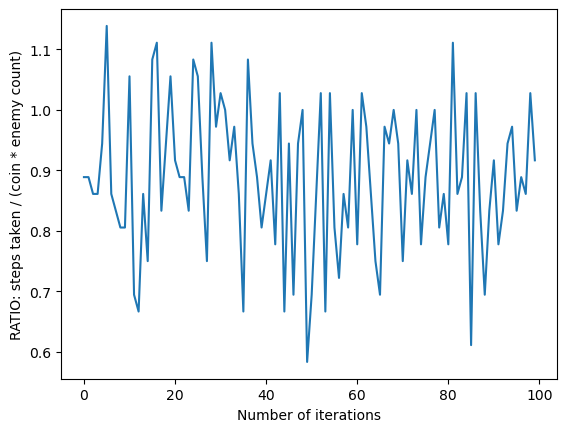

In [179]:
size = 8
nr_of_coins = 6
nr_of_enemies = 6

coin_data = []
enemy_data = []
step_data = []

player_type = 'Neutral'
iteration_num = 100
for iteration in range(0, iteration_num):
    m = Maze(size, nr_of_coins, nr_of_enemies, 'LHS')
    coins_collected, enemies_defeated, steps_taken, path = Player(m, player_type)
    coin_data.append(coins_collected)
    enemy_data.append(enemies_defeated)
    step_data.append(steps_taken)

normalised_data = [m / (nr_of_enemies * nr_of_coins) for m in step_data]
plt.plot(normalised_data)
plt.xlabel('Number of iterations')
plt.ylabel('RATIO: steps taken / (coin * enemy count)')
#plt.xticks(range(0, iteration_num, 1))
#visualise_maze(m, coins_collected, enemies_defeated, steps_taken, path)

In [180]:
satisfaction_list = []
for i in range(len(step_data)):
    satisfaction_list.append(player_satisfaction(nr_of_coins, nr_of_enemies, step_data[i], size, player_type))
print(satisfaction_list)

[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 5, 5, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 1, 1, 3, 1, 5, 1, 5, 1, 1, 2, 5, 1, 1, 5, 1, 2, 5, 1, 2, 1, 3, 1, 1, 1, 4, 5, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1, 5, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# Task 5: Bayesian modelling